# Práctica Series temporales

Se usarán **dos series de bolsa: IAG y Banco de Santander**

1.- **Elegir entre los ficheros** 'iag_2021.csv' y 'santander_2021.csv' y **cargar** uno de ellos

2.- **Detectar la columna que lleva la fecha y cargar el fichero de nuevo indicando la columna que contiene la información temporal**.

3.- **Definir el time series y comprobar si la serie es estacionaria o cómo de lejos está de serlo.**

4.- **Modelizar la tendencia de la serie**

5.- **Extraer las componentes tendencia, estacionalidad y residuo**.

6.- **Modelizar la componente estacionaria (calcula su performance rmse).**

7.- **Repetir el proceso con la otra serie y discutir resultados**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Importación del fichero

In [4]:
file='Datos/santander_2021.csv'
data = pd.read_csv(file) # Se especifica la función a aplicar sobre el objeto fecha
data.head()

,timestamp,hora,ultimo,volumen
0,1.609747e+09,2021-01-04 09:00:26,2.592,1005081
1,1.609747e+09,2021-01-04 09:00:28,2.592,1060093
2,1.609747e+09,2021-01-04 09:00:30,2.589,1076406
3,1.609747e+09,2021-01-04 09:00:31,2.589,1077906
4,1.609747e+09,2021-01-04 09:00:33,2.589,1080910


**Debemos utilizar la columna 'hora' como fecha del dataset y ponerlo de index.

# 2. Poniendo la fecha como index

In [5]:
data=pd.read_csv(file,parse_dates=['hora'],index_col=['hora'])

In [6]:
data.index # COMPROBAMOS QUE INDEX ESTÁ EN FORMATO DATETIME

DatetimeIndex(['2021-01-04 09:00:26', '2021-01-04 09:00:28',
               '2021-01-04 09:00:30', '2021-01-04 09:00:31',
               '2021-01-04 09:00:33', '2021-01-04 09:00:35',
               '2021-01-04 09:00:36', '2021-01-04 09:00:38',
               '2021-01-04 09:00:40', '2021-01-04 09:00:41',
               ...
               '2021-05-14 17:29:40', '2021-05-14 17:29:43',
               '2021-05-14 17:29:45', '2021-05-14 17:29:47',
               '2021-05-14 17:29:49', '2021-05-14 17:29:51',
               '2021-05-14 17:29:53', '2021-05-14 17:29:55',
               '2021-05-14 17:29:57', '2021-05-14 17:29:59'],
              dtype='datetime64[ns]', name='hora', length=1442144, freq=None)

# 3.- Comprobando estacionariedad de la serie

In [7]:
ts = data['ultimo'] # El time series es una serie pandas.
type(ts)

pandas.core.series.Series

In [8]:
print('Primera y última fechas:',ts.index[0],ts.index[-1])
print(ts.head(10))
print()
print(ts.tail(10))

Primera y última fechas: 2021-01-04 09:00:26 2021-05-14 17:29:59
hora
2021-01-04 09:00:26    2.5920
2021-01-04 09:00:28    2.5920
2021-01-04 09:00:30    2.5890
2021-01-04 09:00:31    2.5890
2021-01-04 09:00:33    2.5890
2021-01-04 09:00:35    2.5835
2021-01-04 09:00:36    2.5890
2021-01-04 09:00:38    2.5890
2021-01-04 09:00:40    2.5750
2021-01-04 09:00:41    2.5750
Name: ultimo, dtype: float64

hora
2021-05-14 17:29:40    3.3585
2021-05-14 17:29:43    3.3555
2021-05-14 17:29:45    3.3560
2021-05-14 17:29:47    3.3585
2021-05-14 17:29:49    3.3585
2021-05-14 17:29:51    3.3585
2021-05-14 17:29:53    3.3585
2021-05-14 17:29:55    3.3565
2021-05-14 17:29:57    3.3565
2021-05-14 17:29:59    3.3565
Name: ultimo, dtype: float64


El sampling está hecho a veces a dos segundos y otras veces a uno. Consideremos que el intervalo medio es de alrededor de 1.5 segundos.

Una jornada de cotización empieza a las 9:00 y cierra a las 17:30, que son 8:30 horas, que con un sampling promedio de 1.7 segundos tendrá del orden de 8.5 horas * 60 minutos * 35 samples por minuto=**17850 valores por día**

In [11]:
window=int(round(8.5*60*35,0)) # Usamos como ventana un día completo
ts.index[0]

Timestamp('2021-01-04 09:00:26')

In [12]:
ts.index[window]

Timestamp('2021-01-04 17:23:56')

In [13]:
ts.index[4*window]

Timestamp('2021-01-08 09:10:38')

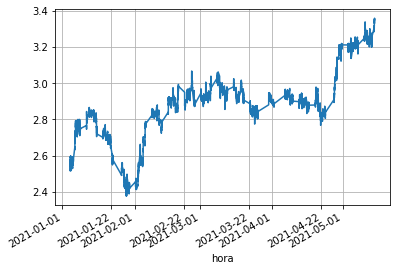

In [14]:
ts.plot(grid=True) 

## Inspección visual de media y desviación móviles

AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


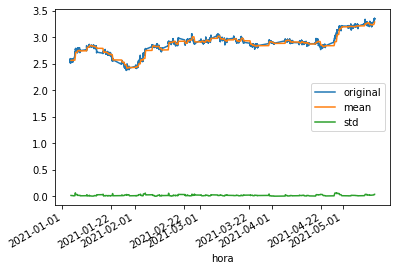

In [15]:
rol_mean=ts.rolling(window=window).mean()
rol_std=ts.rolling(window=window).std()
print(ts.plot(label='original',legend=True))
print(rol_mean.plot(label='mean',legend=True))
print(rol_std.plot(label='std',legend=True))

## Test Dickey-Fuller (DF)


[Reference](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

   - Este test considera como **hipótesis nula** que **la serie es no estacionaria**.

   - **Para aceptar la hipótesis nula** (serie no estacionaria) **el estadístico** (primer valor del resultado) **ha de ser mayor que los valores críticos**.

   - **Otro criterio** para acepatar la hipótesis nula es que el **p-value sea mayor que 0.05** (95% de confianza).



Dado que el fichero es muy largo debemos **partir la serie en tramos**. Procedemos a dividir por días (20400 samples por día)

C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Tramo 0
(-2.007007929544325, 0.2835088451538695, 44, 17805, {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}, -212247.10347883665)

Estadístico -2.007007929544325
P-value 0.2835088451538695
Valores críticos {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}

Tramo 1
(-2.792899764989953, 0.05929516557654066, 37, 17812, {'1%': -3.4307171818239808, '5%': -2.861702280363301, '10%': -2.566856377593907}, -213237.50941855833)

Estadístico -2.792899764989953
P-value 0.05929516557654066
Valores críticos {'1%': -3.4307171818239808, '5%': -2.861702280363301, '10%': -2.566856377593907}

Tramo 2
(-3.7797072342709384, 0.0031218956867980676, 43, 17806, {'1%': -3.4307173055692726, '5%': -2.861702335050618, '10%': -2.566856406703123}, -198743.76028121033)

Estadístico -3.7797072342709384
P-value 0.0031218956867980676
Valores críticos {'1%': -3.4307173055692726, '5%': -2.861702335050618, '10%': -2.566856406703123}

Tramo 3
(-1.40156031054

(-1.7382266388655974, 0.41153231437084337, 12, 17837, {'1%': -3.4307166671148286, '5%': -2.861702052895532, '10%': -2.566856256516322}, -222214.48644061107)

Estadístico -1.7382266388655974
P-value 0.41153231437084337
Valores críticos {'1%': -3.4307166671148286, '5%': -2.861702052895532, '10%': -2.566856256516322}

Tramo 27
(-4.61877454169169, 0.00011925945554536359, 26, 17823, {'1%': -3.430716955174034, '5%': -2.8617021801988587, '10%': -2.5668563242779183}, -220540.9522229528)

Estadístico -4.61877454169169
P-value 0.00011925945554536359
Valores críticos {'1%': -3.430716955174034, '5%': -2.8617021801988587, '10%': -2.5668563242779183}

Tramo 28
(-1.4439743772675884, 0.5610222820512079, 34, 17815, {'1%': -3.4307171199825968, '5%': -2.861702253033458, '10%': -2.5668563630466528}, -221322.2195882406)

Estadístico -1.4439743772675884
P-value 0.5610222820512079
Valores críticos {'1%': -3.4307171199825968, '5%': -2.861702253033458, '10%': -2.5668563630466528}

Tramo 29
(-2.920380900742011,

(-2.1590319749026925, 0.2214488986650438, 44, 17805, {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}, -208858.4222265386)

Estadístico -2.1590319749026925
P-value 0.2214488986650438
Valores críticos {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}

Tramo 53
(-2.0018678485814734, 0.2857547136914439, 44, 17805, {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}, -211360.73229456536)

Estadístico -2.0018678485814734
P-value 0.2857547136914439
Valores críticos {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}

Tramo 54
(-1.8653332514041427, 0.3485409810101967, 41, 17808, {'1%': -3.4307172643115758, '5%': -2.861702316817418, '10%': -2.5668563969978715}, -205337.16034573535)

Estadístico -1.8653332514041427
P-value 0.3485409810101967
Valores críticos {'1%': -3.4307172643115758, '5%': -2.861702316817418, '10%': -2.5668563969978715}

Tramo 55
(-1.854314655660180

(-0.9673990226376641, 0.7649683225899666, 35, 17814, {'1%': -3.430717140594077, '5%': -2.8617022621423827, '10%': -2.566856367895193}, -206126.54396207543)

Estadístico -0.9673990226376641
P-value 0.7649683225899666
Valores críticos {'1%': -3.430717140594077, '5%': -2.8617022621423827, '10%': -2.566856367895193}

Tramo 79
(-1.7209310645612912, 0.4203617052169769, 44, 17805, {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}, -207940.9140087793)

Estadístico -1.7209310645612912
P-value 0.4203617052169769
Valores críticos {'1%': -3.4307173262015977, '5%': -2.8617023441687546, '10%': -2.5668564115565666}

Tramo 80
(-1.3220921143272721, 0.6190055218415845, 38, 14105, {'1%': -3.430813700139929, '5%': -2.8617449344472528, '10%': -2.56687908182554}, -168322.95162680352)

Estadístico -1.3220921143272721
P-value 0.6190055218415845
Valores críticos {'1%': -3.430813700139929, '5%': -2.8617449344472528, '10%': -2.56687908182554}



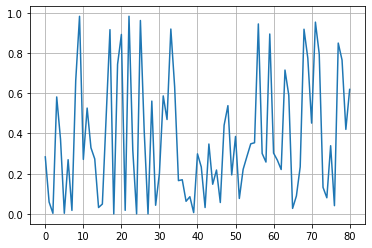

In [16]:
from statsmodels.tsa.stattools import adfuller as df

n_tramos=int(round(len(ts)/window,0)) #Número de tramos

pvalues=[]

for cont in range(0,n_tramos): 
    print('Tramo',cont)
    ts_temp=ts[cont*window:(cont+1)*window]
    result=df(ts_temp,autolag='AIC')
    print(result)
    print()
    print('Estadístico',result[0])
    pvalues.append(result[1])
    print('P-value',result[1])
    print('Valores críticos',result[4])
    print()
plt.plot(pvalues)
plt.grid()
plt.show()

**Se comprueba cuantitativamente que en promedio la serie no es estacionaria dentro de las ventanas diarias para muchos de los días. Sin embargo durante algunos días la serie sí se acerca a la estacionariedad.**

# 4. Modelización de la tendencia

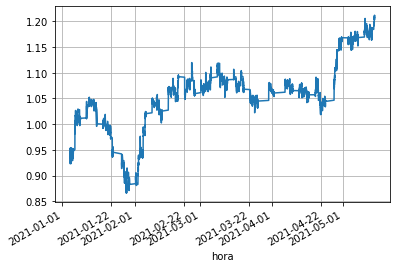

In [17]:
ts_log=np.log(ts)
trend=ts_log.ewm(alpha=0.1).mean().plot(grid=True)

# 5.- Descomposición de componentes

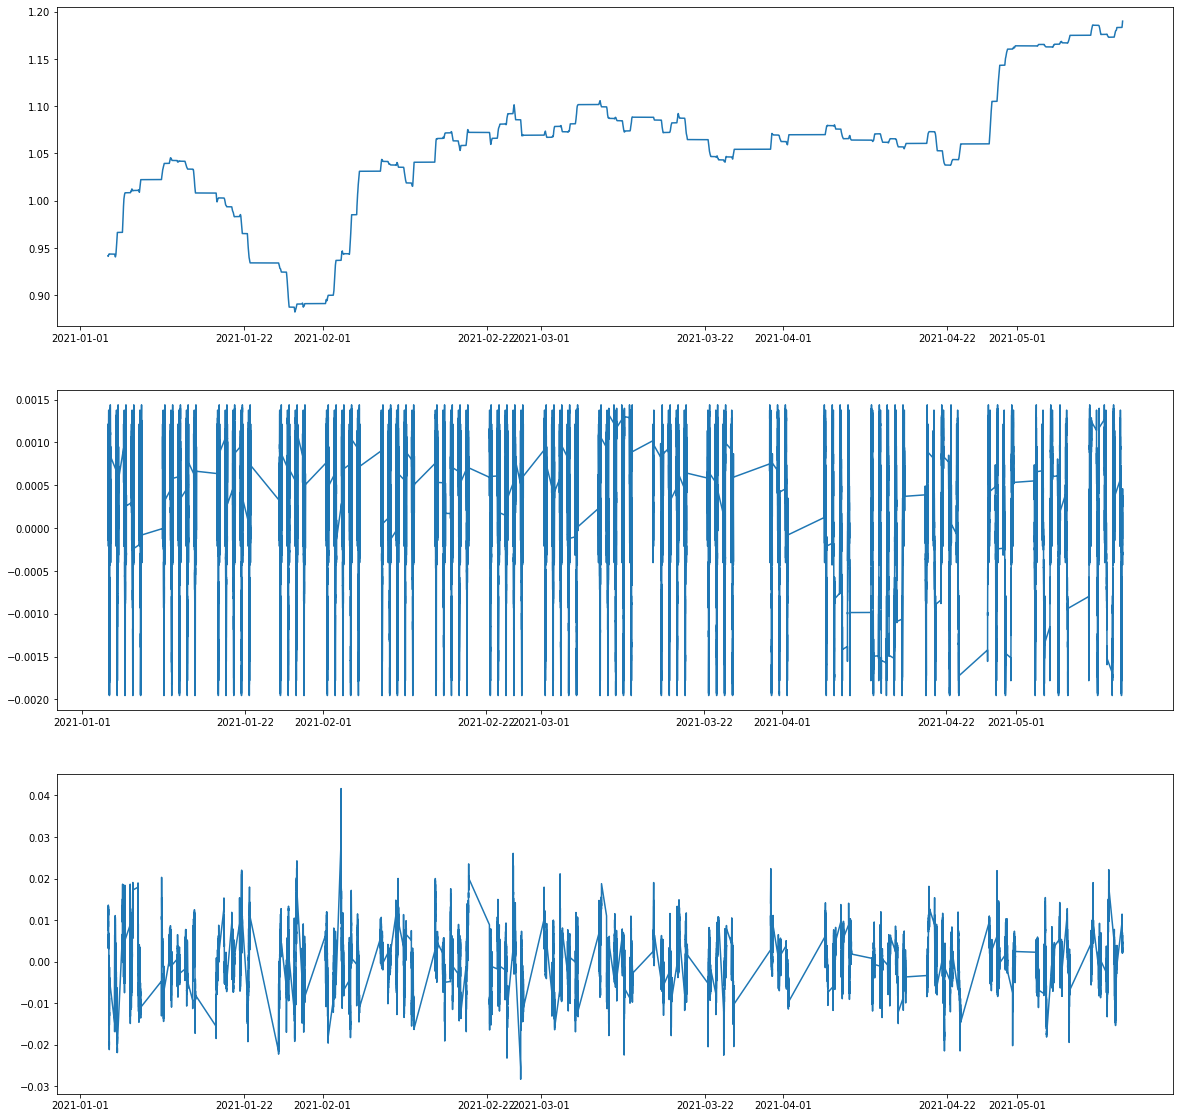

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
result=decompose(ts_log,freq=window) 
trend=result.trend
season=result.seasonal
residuo=result.resid
plt.figure(figsize=(20,20))
plt.subplot(311)
plt.plot(trend)
plt.subplot(312)
plt.plot(season)
plt.subplot(313)
plt.plot(residuo)

# 6. Modelización del residuo

Tramo 0


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


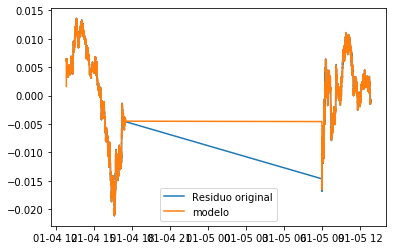

const           0.001602
ar.L1.ultimo    1.897729
ar.L2.ultimo   -0.888993
ar.L3.ultimo   -0.008772
ma.L1.ultimo   -0.930972
dtype: float64

Tramo 1


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


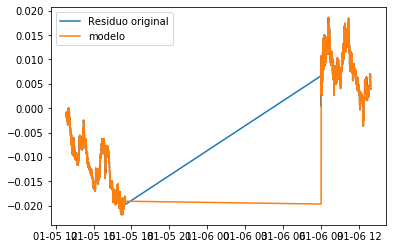

const          -0.001165
ar.L1.ultimo    0.184938
ar.L2.ultimo    0.698423
ar.L3.ultimo    0.115964
ma.L1.ultimo    0.667655
dtype: float64

Tramo 2


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


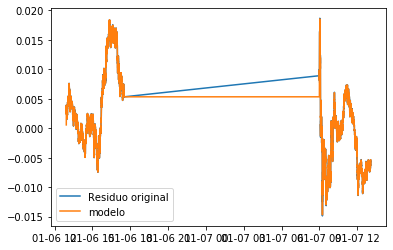

const           0.000550
ar.L1.ultimo    1.716176
ar.L2.ultimo   -0.738232
ar.L3.ultimo    0.021907
ma.L1.ultimo   -0.761856
dtype: float64

Tramo 3


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


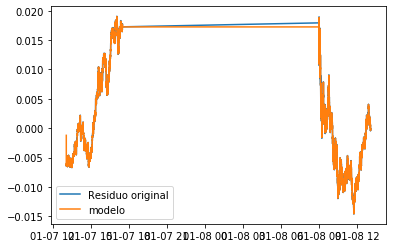

const          -0.001215
ar.L1.ultimo    1.802210
ar.L2.ultimo   -0.796182
ar.L3.ultimo   -0.006071
ma.L1.ultimo   -0.870597
dtype: float64

Tramo 4


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


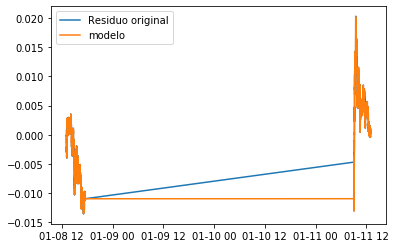

const           0.000723
ar.L1.ultimo    1.807168
ar.L2.ultimo   -0.773883
ar.L3.ultimo   -0.033337
ma.L1.ultimo   -0.877832
dtype: float64

Tramo 5


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


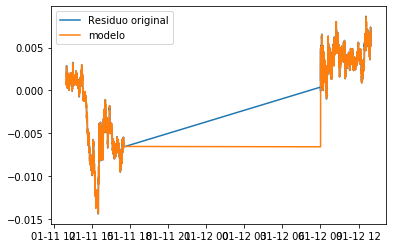

const           0.000902
ar.L1.ultimo    1.850178
ar.L2.ultimo   -0.822074
ar.L3.ultimo   -0.028154
ma.L1.ultimo   -0.913582
dtype: float64

Tramo 6


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


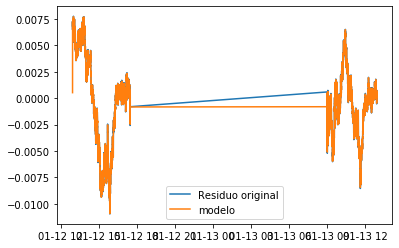

const           0.000515
ar.L1.ultimo    1.866633
ar.L2.ultimo   -0.850316
ar.L3.ultimo   -0.016365
ma.L1.ultimo   -0.931967
dtype: float64

Tramo 7


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


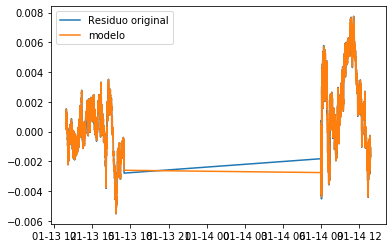

const           0.000952
ar.L1.ultimo    1.869673
ar.L2.ultimo   -0.846148
ar.L3.ultimo   -0.023634
ma.L1.ultimo   -0.931073
dtype: float64

Tramo 8


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


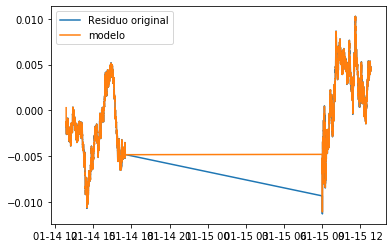

const           0.000299
ar.L1.ultimo    1.879418
ar.L2.ultimo   -0.880089
ar.L3.ultimo    0.000617
ma.L1.ultimo   -0.914815
dtype: float64

Tramo 9


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


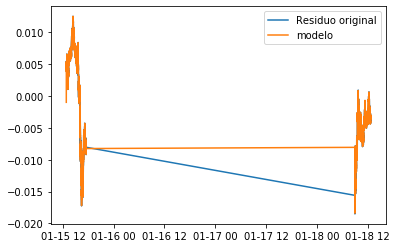

const          -0.001000
ar.L1.ultimo    1.835047
ar.L2.ultimo   -0.819942
ar.L3.ultimo   -0.015150
ma.L1.ultimo   -0.883460
dtype: float64

Tramo 10


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


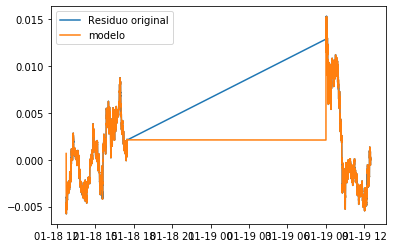

const           0.000672
ar.L1.ultimo    0.786155
ar.L2.ultimo    0.183502
ar.L3.ultimo    0.029349
ma.L1.ultimo    0.202416
dtype: float64

Tramo 11


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


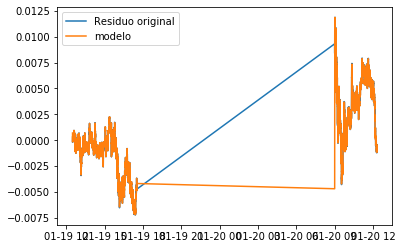

const           0.000696
ar.L1.ultimo    1.434227
ar.L2.ultimo   -0.442172
ar.L3.ultimo    0.007236
ma.L1.ultimo   -0.496927
dtype: float64

Tramo 12


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


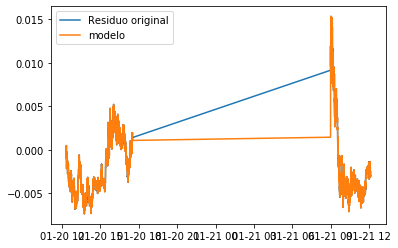

const          -0.002087
ar.L1.ultimo    0.744708
ar.L2.ultimo    0.202063
ar.L3.ultimo    0.051859
ma.L1.ultimo    0.264096
dtype: float64

Tramo 13


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


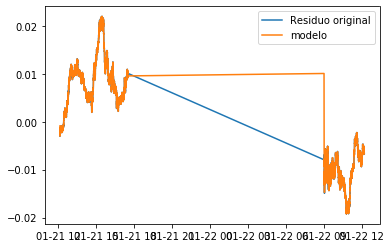

const          -0.000871
ar.L1.ultimo    1.547144
ar.L2.ultimo   -0.580833
ar.L3.ultimo    0.033571
ma.L1.ultimo   -0.584695
dtype: float64

Tramo 14


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


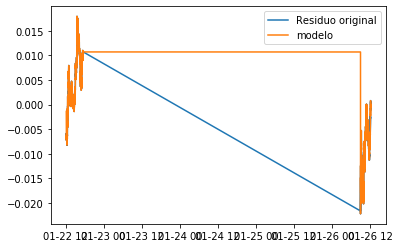

const          -0.001396
ar.L1.ultimo    1.332661
ar.L2.ultimo   -0.349555
ar.L3.ultimo    0.016436
ma.L1.ultimo   -0.350084
dtype: float64

Tramo 15


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


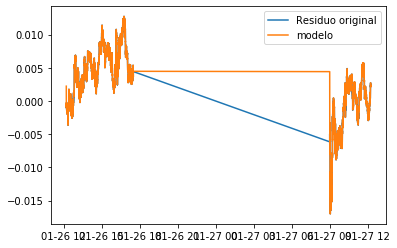

const           0.002232
ar.L1.ultimo    0.026361
ar.L2.ultimo    0.949839
ar.L3.ultimo    0.021540
ma.L1.ultimo    0.943388
dtype: float64

Tramo 16


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


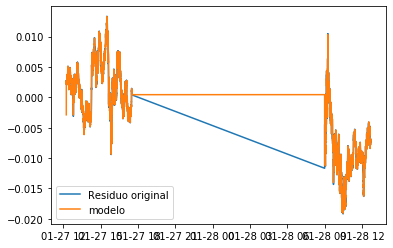

const          -0.002885
ar.L1.ultimo    1.693538
ar.L2.ultimo   -0.669033
ar.L3.ultimo   -0.024674
ma.L1.ultimo   -0.791868
dtype: float64

Tramo 17


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


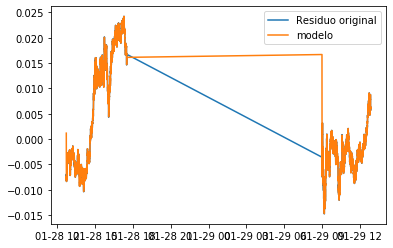

const           0.001173
ar.L1.ultimo    1.712643
ar.L2.ultimo   -0.706727
ar.L3.ultimo   -0.006029
ma.L1.ultimo   -0.763268
dtype: float64

Tramo 18


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


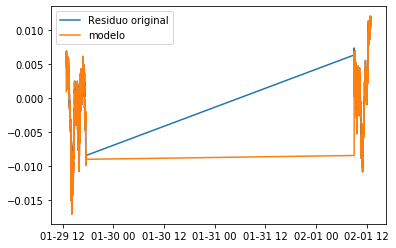

const           0.000930
ar.L1.ultimo    1.851621
ar.L2.ultimo   -0.889872
ar.L3.ultimo    0.038125
ma.L1.ultimo   -0.850763
dtype: float64

Tramo 19


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


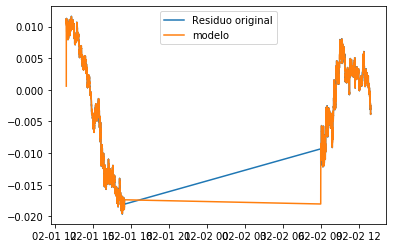

const           0.000581
ar.L1.ultimo    1.855141
ar.L2.ultimo   -0.814393
ar.L3.ultimo   -0.040768
ma.L1.ultimo   -0.926090
dtype: float64

Tramo 20


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


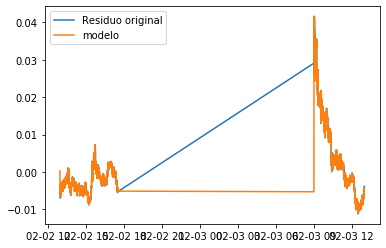

const           0.000265
ar.L1.ultimo    1.188401
ar.L2.ultimo   -0.210475
ar.L3.ultimo    0.021470
ma.L1.ultimo   -0.257550
dtype: float64

Tramo 21


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


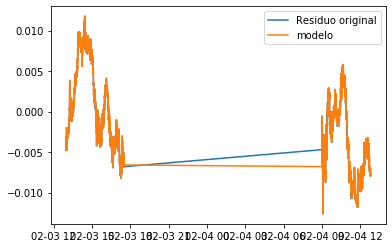

const          -0.002028
ar.L1.ultimo    0.215860
ar.L2.ultimo    0.758299
ar.L3.ultimo    0.024862
ma.L1.ultimo    0.743938
dtype: float64

Tramo 22


C:\Users\juanh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
from statsmodels.tsa.arima_model import ARIMA as arima

residuo=residuo.dropna()
order=(3,0,1)
n_tramos=int(round(len(ts)/window,0)) #Número de tramos

models=[]

for cont in range(0,n_tramos): 
    print('Tramo',cont)
    residuo_temp=residuo[cont*window:(cont+1)*window]
    modelo=arima(residuo_temp,order=order)
    results=modelo.fit()
    plt.plot(residuo_temp,label='Residuo original')
    plt.plot(results.fittedvalues,label='modelo')
    plt.legend()
    plt.show()
    models.append(results.fittedvalues)
    print(results.params)
    print()
